In [7]:
# !pip install -q tensorflow-recommenders
# !pip install -q --upgrade tensorflow-datasets
# !pip install -q scann

In [8]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import pandas as pd
import sampling
import pickle


# Constants 

In [9]:
RATINGS_SMALL = "../EDA_files/ratings_small.parquet"
RECIPES_SMALL = "../EDA_files/recipes_small.parquet"
INDEX_TO_RECIPE_OBJ = "../EDA_files/index_to_recipe.obj"
RECIPE_TO_INDEX_OBJ = "../EDA_files/recipe_to_index.obj"

ING_CLEAN_NO_COMMON = '../cleaned_files/ingredients_clean_without_common_words.obj'
KEYWORDS_CLEAN = '../cleaned_files/keywords_cleaned.obj'
CATEGORIES_CLEAN = '../cleaned_files/categories_cleaned.obj'
NAMES_CLEAN = '../cleaned_files/names_cleaned.obj'

RECIPES_DATA = "../dataset/recipes.parquet"

# Load data 

In [10]:
recipes_small = pd.read_parquet(RECIPES_SMALL)
ratings_small = pd.read_parquet(RATINGS_SMALL)

In [11]:
with open(RECIPE_TO_INDEX_OBJ, "rb") as input_file:
    recipe_to_index = pickle.load(input_file)

In [12]:
# with open(ING_CLEAN_NO_COMMON, "rb") as input_file:
#     ingredients_no_common_words = pickle.load(input_file)

# with open(KEYWORDS_CLEAN, "rb") as input_file:
#     keywords_clean = pickle.load(input_file)

# with open(CATEGORIES_CLEAN, "rb") as input_file:
#     categories_clean = pickle.load(input_file)
    
# with open(NAMES_CLEAN, "rb") as input_file:
#     names_clean = pickle.load(input_file)

## Prepare ratings sample

In [13]:
author_min_20 = sampling.get_rating_with_min_number(ratings_small, 20, col_name='AuthorId')
recipe_min_20 = sampling.get_rating_with_min_number(ratings_small, 20, col_name='RecipeId')

ratings_min_20 = author_min_20.merge(recipe_min_20, how='inner')

In [14]:
ratings_sample = ratings_min_20.copy()

## Prepare recipes sample

In [15]:
# ingredients_no_common_words.Ingredients = ingredients_no_common_words.Ingredients.map(lambda x: ' '.join(x))

In [16]:
# keywords_clean.Keywords = keywords_clean.Keywords.map(lambda x: ' '.join(x)) 

In [17]:
# recipes_clean = recipes_small.copy()
# recipes_clean.drop(columns=['Ingredients', 'Keywords', 'RecipeCategory', 'Nutritions'], axis=1, inplace=True)
# recipes_clean = recipes_clean.merge(ingredients_no_common_words, on='RecipeId')
# recipes_clean = recipes_clean.merge(keywords_clean, on='RecipeId')
# recipes_clean = recipes_clean.merge(categories_clean, on='RecipeId')

# sample = recipes[['RecipeId', 'Calories', 'FatContent', 'SaturatedFatContent',
#                                             'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
#                                             'FiberContent', 'SugarContent', 'ProteinContent']]

# recipes_clean = recipes_clean.merge(sample, on='RecipeId')

In [18]:
recipes_sample = recipes_small[recipes_small.RecipeId.isin(list(ratings_min_20.RecipeId))].copy()

# Prepare dataset

## Ratings

For ranking task - only AuthorId - RecipeId pairs are used

In [19]:
ratings_sample.AuthorId = ratings_sample.AuthorId.map(lambda x: bytes(str(x), 'utf-8'))
ratings_sample.RecipeId = ratings_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

In [20]:
ratings_dict = ratings_sample.groupby(['AuthorId', 'RecipeId'])['Rating'].sum().reset_index()

In [21]:
ratings_dict = {name: np.array(value) for name, value in ratings_dict.items()}
ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)


In [22]:
ratings = ratings.map(lambda x: {'AuthorId' : x['AuthorId'], 
                                 'RecipeId' : x['RecipeId'],})

In [23]:
for x in ratings.take(10).as_numpy_iterator():
    pprint.pprint(x)

{'AuthorId': b'100026', 'RecipeId': b'120914'}
{'AuthorId': b'100026', 'RecipeId': b'143736'}
{'AuthorId': b'100026', 'RecipeId': b'161324'}
{'AuthorId': b'100026', 'RecipeId': b'161335'}
{'AuthorId': b'100026', 'RecipeId': b'161381'}
{'AuthorId': b'100026', 'RecipeId': b'172588'}
{'AuthorId': b'100026', 'RecipeId': b'195437'}
{'AuthorId': b'100026', 'RecipeId': b'33201'}
{'AuthorId': b'100026', 'RecipeId': b'39165'}
{'AuthorId': b'100026', 'RecipeId': b'8739'}


## Recipes

In [24]:
# recipes_clean.info()

In [25]:
features = ["RecipeId", "Name", "Keywords", "Ingredients", "FatContent", "SaturatedFatContent", "CholesterolContent", "SodiumContent",
           "CarbohydrateContent", "FiberContent","SugarContent", "ProteinContent"]

In [26]:
recipes_sample.RecipeId = recipes_sample.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))
recipes_dict = recipes_sample[['RecipeId']]
recipes_dict = {name: np.array(value) for name, value in recipes_dict.items()}
recipes = tf.data.Dataset.from_tensor_slices(recipes_dict)

In [27]:
recipes = recipes.map(lambda x: x['RecipeId'])

## RANKING

In [28]:
size = ratings_sample.shape[0]
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = size - train_size - val_size

tf.random.set_seed(42)
shuffled = ratings.shuffle(size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
val = shuffled.take(train_size).take(val_size)
test = shuffled.take(train_size).take(val_size).take(test_size)

In [29]:
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Val size: {val_size}")      

Train size: 217015
Test size: 46504
Val size: 46503


In [30]:
recipe_ids = recipes.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["AuthorId"])

unique_recipe_ids = np.unique(np.concatenate(list(recipe_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [31]:
# unique_user_ids = [bytes(str(x), 'utf-8') for x in unique_user_ids]

In [32]:
# unique_recipe_ids = [bytes(str(x), 'utf-8') for x in unique_recipe_ids]

# Implementing model

## Query tower

In [33]:
embedding_dimension = 32

In [34]:
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

## Candidate tower

In [35]:
recipe_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_recipe_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, embedding_dimension)
])

## Model

In [36]:
class RecipeModel(tfrs.Model):
    def __init__(self, user_model, recipe_model):
        super().__init__()
        self.recipe_model: tf.keras.Model = recipe_model
        self.user_model: tf.keras.Model = user_model
        
        
        metrics = tfrs.metrics.FactorizedTopK(candidates=recipes.batch(128).map(recipe_model))
        task = tfrs.tasks.Retrieval(metrics=metrics)
        self.task: tf.keras.layers.Layer = task
            
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["AuthorId"])
        positive_recipe_embeddings = self.recipe_model(features["RecipeId"])
        
        return self.task(user_embeddings, positive_recipe_embeddings)

# Train & test

In [37]:
model_1 = RecipeModel(user_model=user_model, recipe_model=recipe_model)
model_1.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [38]:
cached_train = train.shuffle(250_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
cached_val = val.batch(4096).cache()

## Fit first 300 epochs

In [39]:
%%time
model_1_history = model_1.fit(cached_train,
                              epochs=300, 
                              verbose=1,
                              validation_data=cached_val,
                              validation_freq=5)

Epoch 1/300
27/27 [==============================] - 174s 6s/step - factorized_top_k/top_1_categorical_accuracy: 1.4285e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0020 - factorized_top_k/top_10_categorical_accuracy: 0.0043 - factorized_top_k/top_50_categorical_accuracy: 0.0174 - factorized_top_k/top_100_categorical_accuracy: 0.0296 - loss: 70851.7609 - regularization_loss: 0.0000e+00 - total_loss: 70851.7609
Epoch 2/300
27/27 [==============================] - 173s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0122 - factorized_top_k/top_10_categorical_accuracy: 0.0221 - factorized_top_k/top_50_categorical_accuracy: 0.0723 - factorized_top_k/top_100_categorical_accuracy: 0.1120 - loss: 69374.2500 - regularization_loss: 0.0000e+00 - total_loss: 69374.2500
Epoch 3/300
27/27 [==============================] - 173s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_acc

27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0633 - factorized_top_k/top_10_categorical_accuracy: 0.1052 - factorized_top_k/top_50_categorical_accuracy: 0.2566 - factorized_top_k/top_100_categorical_accuracy: 0.3495 - loss: 55874.7476 - regularization_loss: 0.0000e+00 - total_loss: 55874.7476
Epoch 18/300
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0644 - factorized_top_k/top_10_categorical_accuracy: 0.1067 - factorized_top_k/top_50_categorical_accuracy: 0.2587 - factorized_top_k/top_100_categorical_accuracy: 0.3519 - loss: 55716.0949 - regularization_loss: 0.0000e+00 - total_loss: 55716.0949
Epoch 19/300
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0652 

27/27 [==============================] - 172s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0054 - factorized_top_k/top_5_categorical_accuracy: 0.0744 - factorized_top_k/top_10_categorical_accuracy: 0.1225 - factorized_top_k/top_50_categorical_accuracy: 0.2831 - factorized_top_k/top_100_categorical_accuracy: 0.3781 - loss: 54370.8779 - regularization_loss: 0.0000e+00 - total_loss: 54370.8779
Epoch 34/300
27/27 [==============================] - 175s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0056 - factorized_top_k/top_5_categorical_accuracy: 0.0751 - factorized_top_k/top_10_categorical_accuracy: 0.1234 - factorized_top_k/top_50_categorical_accuracy: 0.2843 - factorized_top_k/top_100_categorical_accuracy: 0.3796 - loss: 54316.0841 - regularization_loss: 0.0000e+00 - total_loss: 54316.0841
Epoch 35/300
27/27 [==============================] - 207s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0054 - factorized_top_k/top_5_categorical_accuracy: 0.0754 

27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0056 - factorized_top_k/top_5_categorical_accuracy: 0.0810 - factorized_top_k/top_10_categorical_accuracy: 0.1332 - factorized_top_k/top_50_categorical_accuracy: 0.2995 - factorized_top_k/top_100_categorical_accuracy: 0.3934 - loss: 53700.4523 - regularization_loss: 0.0000e+00 - total_loss: 53700.4523
Epoch 50/300
27/27 [==============================] - 202s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0054 - factorized_top_k/top_5_categorical_accuracy: 0.0813 - factorized_top_k/top_10_categorical_accuracy: 0.1337 - factorized_top_k/top_50_categorical_accuracy: 0.3001 - factorized_top_k/top_100_categorical_accuracy: 0.3942 - loss: 53668.9397 - regularization_loss: 0.0000e+00 - total_loss: 53668.9397 - val_factorized_top_k/top_1_categorical_accuracy: 0.0194 - val_factorized_top_k/top_5_categorical_accuracy: 0.0974 - val_factorized_top_k/top_10_categorical_accuracy: 0.1490 

27/27 [==============================] - 202s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.0856 - factorized_top_k/top_10_categorical_accuracy: 0.1400 - factorized_top_k/top_50_categorical_accuracy: 0.3100 - factorized_top_k/top_100_categorical_accuracy: 0.4035 - loss: 53278.4876 - regularization_loss: 0.0000e+00 - total_loss: 53278.4876 - val_factorized_top_k/top_1_categorical_accuracy: 0.0191 - val_factorized_top_k/top_5_categorical_accuracy: 0.1013 - val_factorized_top_k/top_10_categorical_accuracy: 0.1552 - val_factorized_top_k/top_50_categorical_accuracy: 0.3227 - val_factorized_top_k/top_100_categorical_accuracy: 0.4136 - val_loss: 7268.3521 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7268.3521
Epoch 66/300
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.0859 - factorized_top_k/top_10_categorical

Epoch 81/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0060 - factorized_top_k/top_5_categorical_accuracy: 0.0885 - factorized_top_k/top_10_categorical_accuracy: 0.1456 - factorized_top_k/top_50_categorical_accuracy: 0.3177 - factorized_top_k/top_100_categorical_accuracy: 0.4105 - loss: 52973.7001 - regularization_loss: 0.0000e+00 - total_loss: 52973.7001
Epoch 82/300
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0059 - factorized_top_k/top_5_categorical_accuracy: 0.0888 - factorized_top_k/top_10_categorical_accuracy: 0.1459 - factorized_top_k/top_50_categorical_accuracy: 0.3181 - factorized_top_k/top_100_categorical_accuracy: 0.4108 - loss: 52957.2224 - regularization_loss: 0.0000e+00 - total_loss: 52957.2224
Epoch 83/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0060 - factorized_top_k/top_5_categorical_accu

27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0059 - factorized_top_k/top_5_categorical_accuracy: 0.0908 - factorized_top_k/top_10_categorical_accuracy: 0.1497 - factorized_top_k/top_50_categorical_accuracy: 0.3239 - factorized_top_k/top_100_categorical_accuracy: 0.4166 - loss: 52736.4088 - regularization_loss: 0.0000e+00 - total_loss: 52736.4088
Epoch 98/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0060 - factorized_top_k/top_5_categorical_accuracy: 0.0909 - factorized_top_k/top_10_categorical_accuracy: 0.1498 - factorized_top_k/top_50_categorical_accuracy: 0.3242 - factorized_top_k/top_100_categorical_accuracy: 0.4169 - loss: 52723.2003 - regularization_loss: 0.0000e+00 - total_loss: 52723.2003
Epoch 99/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.0912 

27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0060 - factorized_top_k/top_5_categorical_accuracy: 0.0931 - factorized_top_k/top_10_categorical_accuracy: 0.1535 - factorized_top_k/top_50_categorical_accuracy: 0.3290 - factorized_top_k/top_100_categorical_accuracy: 0.4210 - loss: 52542.6931 - regularization_loss: 0.0000e+00 - total_loss: 52542.6931
Epoch 114/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0061 - factorized_top_k/top_5_categorical_accuracy: 0.0931 - factorized_top_k/top_10_categorical_accuracy: 0.1539 - factorized_top_k/top_50_categorical_accuracy: 0.3294 - factorized_top_k/top_100_categorical_accuracy: 0.4213 - loss: 52531.6960 - regularization_loss: 0.0000e+00 - total_loss: 52531.6960
Epoch 115/300
27/27 [==============================] - 200s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.093

27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0061 - factorized_top_k/top_5_categorical_accuracy: 0.0944 - factorized_top_k/top_10_categorical_accuracy: 0.1568 - factorized_top_k/top_50_categorical_accuracy: 0.3333 - factorized_top_k/top_100_categorical_accuracy: 0.4252 - loss: 52379.2937 - regularization_loss: 0.0000e+00 - total_loss: 52379.2937
Epoch 130/300
27/27 [==============================] - 200s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0061 - factorized_top_k/top_5_categorical_accuracy: 0.0944 - factorized_top_k/top_10_categorical_accuracy: 0.1569 - factorized_top_k/top_50_categorical_accuracy: 0.3335 - factorized_top_k/top_100_categorical_accuracy: 0.4254 - loss: 52369.8852 - regularization_loss: 0.0000e+00 - total_loss: 52369.8852 - val_factorized_top_k/top_1_categorical_accuracy: 0.0200 - val_factorized_top_k/top_5_categorical_accuracy: 0.1104 - val_factorized_top_k/top_10_categorical_accuracy: 0.1705

27/27 [==============================] - 200s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0061 - factorized_top_k/top_5_categorical_accuracy: 0.0957 - factorized_top_k/top_10_categorical_accuracy: 0.1597 - factorized_top_k/top_50_categorical_accuracy: 0.3372 - factorized_top_k/top_100_categorical_accuracy: 0.4285 - loss: 52238.1378 - regularization_loss: 0.0000e+00 - total_loss: 52238.1378 - val_factorized_top_k/top_1_categorical_accuracy: 0.0201 - val_factorized_top_k/top_5_categorical_accuracy: 0.1119 - val_factorized_top_k/top_10_categorical_accuracy: 0.1736 - val_factorized_top_k/top_50_categorical_accuracy: 0.3468 - val_factorized_top_k/top_100_categorical_accuracy: 0.4349 - val_loss: 7105.5889 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7105.5889
Epoch 146/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.0957 - factorized_top_k/top_10_categorica

Epoch 161/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.0969 - factorized_top_k/top_10_categorical_accuracy: 0.1622 - factorized_top_k/top_50_categorical_accuracy: 0.3402 - factorized_top_k/top_100_categorical_accuracy: 0.4312 - loss: 52113.9682 - regularization_loss: 0.0000e+00 - total_loss: 52113.9682
Epoch 162/300
27/27 [==============================] - 170s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.0970 - factorized_top_k/top_10_categorical_accuracy: 0.1623 - factorized_top_k/top_50_categorical_accuracy: 0.3404 - factorized_top_k/top_100_categorical_accuracy: 0.4314 - loss: 52106.6830 - regularization_loss: 0.0000e+00 - total_loss: 52106.6830
Epoch 163/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_a

27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.0979 - factorized_top_k/top_10_categorical_accuracy: 0.1643 - factorized_top_k/top_50_categorical_accuracy: 0.3430 - factorized_top_k/top_100_categorical_accuracy: 0.4340 - loss: 52003.1807 - regularization_loss: 0.0000e+00 - total_loss: 52003.1807
Epoch 178/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.0979 - factorized_top_k/top_10_categorical_accuracy: 0.1643 - factorized_top_k/top_50_categorical_accuracy: 0.3431 - factorized_top_k/top_100_categorical_accuracy: 0.4341 - loss: 51996.6377 - regularization_loss: 0.0000e+00 - total_loss: 51996.6377
Epoch 179/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.098

27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.0989 - factorized_top_k/top_10_categorical_accuracy: 0.1662 - factorized_top_k/top_50_categorical_accuracy: 0.3454 - factorized_top_k/top_100_categorical_accuracy: 0.4362 - loss: 51903.1960 - regularization_loss: 0.0000e+00 - total_loss: 51903.1960
Epoch 194/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.0989 - factorized_top_k/top_10_categorical_accuracy: 0.1663 - factorized_top_k/top_50_categorical_accuracy: 0.3456 - factorized_top_k/top_100_categorical_accuracy: 0.4363 - loss: 51897.2596 - regularization_loss: 0.0000e+00 - total_loss: 51897.2596
Epoch 195/300
27/27 [==============================] - 200s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.099

27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.0996 - factorized_top_k/top_10_categorical_accuracy: 0.1681 - factorized_top_k/top_50_categorical_accuracy: 0.3480 - factorized_top_k/top_100_categorical_accuracy: 0.4386 - loss: 51812.1148 - regularization_loss: 0.0000e+00 - total_loss: 51812.1148
Epoch 210/300
27/27 [==============================] - 200s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.0997 - factorized_top_k/top_10_categorical_accuracy: 0.1681 - factorized_top_k/top_50_categorical_accuracy: 0.3482 - factorized_top_k/top_100_categorical_accuracy: 0.4387 - loss: 51806.6843 - regularization_loss: 0.0000e+00 - total_loss: 51806.6843 - val_factorized_top_k/top_1_categorical_accuracy: 0.0204 - val_factorized_top_k/top_5_categorical_accuracy: 0.1151 - val_factorized_top_k/top_10_categorical_accuracy: 0.1812

27/27 [==============================] - 200s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.1003 - factorized_top_k/top_10_categorical_accuracy: 0.1698 - factorized_top_k/top_50_categorical_accuracy: 0.3500 - factorized_top_k/top_100_categorical_accuracy: 0.4402 - loss: 51728.4914 - regularization_loss: 0.0000e+00 - total_loss: 51728.4914 - val_factorized_top_k/top_1_categorical_accuracy: 0.0209 - val_factorized_top_k/top_5_categorical_accuracy: 0.1160 - val_factorized_top_k/top_10_categorical_accuracy: 0.1831 - val_factorized_top_k/top_50_categorical_accuracy: 0.3591 - val_factorized_top_k/top_100_categorical_accuracy: 0.4453 - val_loss: 7021.6807 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7021.6807
Epoch 226/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.1004 - factorized_top_k/top_10_categorica

Epoch 241/300
27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accuracy: 0.1012 - factorized_top_k/top_10_categorical_accuracy: 0.1715 - factorized_top_k/top_50_categorical_accuracy: 0.3522 - factorized_top_k/top_100_categorical_accuracy: 0.4419 - loss: 51651.2030 - regularization_loss: 0.0000e+00 - total_loss: 51651.2030
Epoch 242/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.1011 - factorized_top_k/top_10_categorical_accuracy: 0.1715 - factorized_top_k/top_50_categorical_accuracy: 0.3523 - factorized_top_k/top_100_categorical_accuracy: 0.4420 - loss: 51646.5607 - regularization_loss: 0.0000e+00 - total_loss: 51646.5607
Epoch 243/300
27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_a

27/27 [==============================] - 169s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.1021 - factorized_top_k/top_10_categorical_accuracy: 0.1728 - factorized_top_k/top_50_categorical_accuracy: 0.3542 - factorized_top_k/top_100_categorical_accuracy: 0.4432 - loss: 51579.3617 - regularization_loss: 0.0000e+00 - total_loss: 51579.3617
Epoch 258/300
27/27 [==============================] - 173s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.1020 - factorized_top_k/top_10_categorical_accuracy: 0.1729 - factorized_top_k/top_50_categorical_accuracy: 0.3544 - factorized_top_k/top_100_categorical_accuracy: 0.4433 - loss: 51575.0354 - regularization_loss: 0.0000e+00 - total_loss: 51575.0354
Epoch 259/300
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.102

27/27 [==============================] - 167s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.1028 - factorized_top_k/top_10_categorical_accuracy: 0.1741 - factorized_top_k/top_50_categorical_accuracy: 0.3556 - factorized_top_k/top_100_categorical_accuracy: 0.4449 - loss: 51512.2535 - regularization_loss: 0.0000e+00 - total_loss: 51512.2535
Epoch 274/300
27/27 [==============================] - 167s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.1028 - factorized_top_k/top_10_categorical_accuracy: 0.1741 - factorized_top_k/top_50_categorical_accuracy: 0.3559 - factorized_top_k/top_100_categorical_accuracy: 0.4450 - loss: 51508.2016 - regularization_loss: 0.0000e+00 - total_loss: 51508.2016
Epoch 275/300
27/27 [==============================] - 198s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.102

27/27 [==============================] - 168s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.1033 - factorized_top_k/top_10_categorical_accuracy: 0.1755 - factorized_top_k/top_50_categorical_accuracy: 0.3574 - factorized_top_k/top_100_categorical_accuracy: 0.4463 - loss: 51449.2960 - regularization_loss: 0.0000e+00 - total_loss: 51449.2960
Epoch 290/300
27/27 [==============================] - 198s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy: 0.1033 - factorized_top_k/top_10_categorical_accuracy: 0.1756 - factorized_top_k/top_50_categorical_accuracy: 0.3575 - factorized_top_k/top_100_categorical_accuracy: 0.4464 - loss: 51445.4865 - regularization_loss: 0.0000e+00 - total_loss: 51445.4865 - val_factorized_top_k/top_1_categorical_accuracy: 0.0208 - val_factorized_top_k/top_5_categorical_accuracy: 0.1195 - val_factorized_top_k/top_10_categorical_accuracy: 0.1885

### Save

In [40]:
model_1.save_weights('../TFRS/basic/ranking/model_1/model1_ranking_300_epochs_checkpoint')
with open('../TFRS/basic/ranking/model_1/model1_history.obj', 'wb') as pickle_file:
    pickle.dump(model_1_history.history, pickle_file)

### Plot

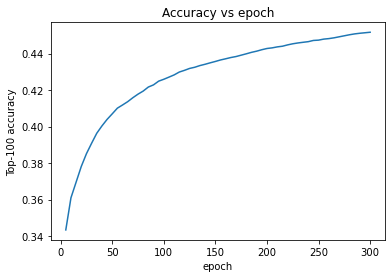

In [41]:
import matplotlib.pyplot as plt

num_validation_runs = len(model_1_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model_1_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
# plt.legend()

### Test

In [45]:
evaluated_model_300epochs = model_1.evaluate(cached_test, return_dict=True)

12/12 [==============================] - 33s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0205 - factorized_top_k/top_5_categorical_accuracy: 0.1194 - factorized_top_k/top_10_categorical_accuracy: 0.1891 - factorized_top_k/top_50_categorical_accuracy: 0.3666 - factorized_top_k/top_100_categorical_accuracy: 0.4517 - loss: 21321.1762 - regularization_loss: 0.0000e+00 - total_loss: 21321.1762


In [50]:
print("Evaluated metrics:")
for metric in evaluated_model_300epochs.items():
    print(f"{metric[0]}: {metric[1]}")

Evaluated metrics:
factorized_top_k/top_1_categorical_accuracy: 0.020514804869890213
factorized_top_k/top_5_categorical_accuracy: 0.11939014494419098
factorized_top_k/top_10_categorical_accuracy: 0.18908457458019257
factorized_top_k/top_50_categorical_accuracy: 0.3666430115699768
factorized_top_k/top_100_categorical_accuracy: 0.4516697824001312
loss: 6967.71044921875
regularization_loss: 0
total_loss: 6967.71044921875


In [53]:
index = tfrs.layers.factorized_top_k.BruteForce(model_1.user_model)
index.index_from_dataset(tf.data.Dataset.zip((recipes.batch(100), recipes.batch(100).map(model_1.recipe_model))))

x, titles = index(tf.constant([b'2695']))

In [56]:
print(f"Recommendations for user 42: {titles[0, :3]}")

Recommendations for user 42: [b'4807' b'57033' b'104604']


## Fit next 100 epochs

In [58]:
%%time
model_1_history_part2 = model_1.fit(cached_train,
                              epochs=100, 
                              verbose=1,
                              validation_data=cached_val,
                              validation_freq=5)

Epoch 1/100
27/27 [==============================] - 172s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.1038 - factorized_top_k/top_10_categorical_accuracy: 0.1764 - factorized_top_k/top_50_categorical_accuracy: 0.3586 - factorized_top_k/top_100_categorical_accuracy: 0.4472 - loss: 51404.5057 - regularization_loss: 0.0000e+00 - total_loss: 51404.5057
Epoch 2/100
27/27 [==============================] - 170s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accuracy: 0.1038 - factorized_top_k/top_10_categorical_accuracy: 0.1765 - factorized_top_k/top_50_categorical_accuracy: 0.3586 - factorized_top_k/top_100_categorical_accuracy: 0.4473 - loss: 51400.8612 - regularization_loss: 0.0000e+00 - total_loss: 51400.8612
Epoch 3/100
27/27 [==============================] - 170s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0068 - factorized_top_k/top_5_categorical_accurac

27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accuracy: 0.1043 - factorized_top_k/top_10_categorical_accuracy: 0.1776 - factorized_top_k/top_50_categorical_accuracy: 0.3597 - factorized_top_k/top_100_categorical_accuracy: 0.4484 - loss: 51347.6996 - regularization_loss: 0.0000e+00 - total_loss: 51347.6996
Epoch 18/100
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accuracy: 0.1043 - factorized_top_k/top_10_categorical_accuracy: 0.1777 - factorized_top_k/top_50_categorical_accuracy: 0.3599 - factorized_top_k/top_100_categorical_accuracy: 0.4485 - loss: 51344.2503 - regularization_loss: 0.0000e+00 - total_loss: 51344.2503
Epoch 19/100
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.1042 

27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0064 - factorized_top_k/top_5_categorical_accuracy: 0.1045 - factorized_top_k/top_10_categorical_accuracy: 0.1785 - factorized_top_k/top_50_categorical_accuracy: 0.3612 - factorized_top_k/top_100_categorical_accuracy: 0.4496 - loss: 51293.8931 - regularization_loss: 0.0000e+00 - total_loss: 51293.8931
Epoch 34/100
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.1048 - factorized_top_k/top_10_categorical_accuracy: 0.1787 - factorized_top_k/top_50_categorical_accuracy: 0.3612 - factorized_top_k/top_100_categorical_accuracy: 0.4497 - loss: 51290.6247 - regularization_loss: 0.0000e+00 - total_loss: 51290.6247
Epoch 35/100
27/27 [==============================] - 202s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.1046 

27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.1051 - factorized_top_k/top_10_categorical_accuracy: 0.1797 - factorized_top_k/top_50_categorical_accuracy: 0.3625 - factorized_top_k/top_100_categorical_accuracy: 0.4506 - loss: 51242.7965 - regularization_loss: 0.0000e+00 - total_loss: 51242.7965
Epoch 50/100
27/27 [==============================] - 201s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.1052 - factorized_top_k/top_10_categorical_accuracy: 0.1798 - factorized_top_k/top_50_categorical_accuracy: 0.3626 - factorized_top_k/top_100_categorical_accuracy: 0.4507 - loss: 51239.6850 - regularization_loss: 0.0000e+00 - total_loss: 51239.6850 - val_factorized_top_k/top_1_categorical_accuracy: 0.0209 - val_factorized_top_k/top_5_categorical_accuracy: 0.1210 - val_factorized_top_k/top_10_categorical_accuracy: 0.1927 

27/27 [==============================] - 203s 8s/step - factorized_top_k/top_1_categorical_accuracy: 0.0066 - factorized_top_k/top_5_categorical_accuracy: 0.1055 - factorized_top_k/top_10_categorical_accuracy: 0.1805 - factorized_top_k/top_50_categorical_accuracy: 0.3637 - factorized_top_k/top_100_categorical_accuracy: 0.4518 - loss: 51194.1430 - regularization_loss: 0.0000e+00 - total_loss: 51194.1430 - val_factorized_top_k/top_1_categorical_accuracy: 0.0208 - val_factorized_top_k/top_5_categorical_accuracy: 0.1213 - val_factorized_top_k/top_10_categorical_accuracy: 0.1933 - val_factorized_top_k/top_50_categorical_accuracy: 0.3708 - val_factorized_top_k/top_100_categorical_accuracy: 0.4557 - val_loss: 6931.4058 - val_regularization_loss: 0.0000e+00 - val_total_loss: 6931.4058
Epoch 66/100
27/27 [==============================] - 171s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accuracy: 0.1052 - factorized_top_k/top_10_categorical

Epoch 81/100
27/27 [==============================] - 174s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.1058 - factorized_top_k/top_10_categorical_accuracy: 0.1818 - factorized_top_k/top_50_categorical_accuracy: 0.3648 - factorized_top_k/top_100_categorical_accuracy: 0.4528 - loss: 51147.7146 - regularization_loss: 0.0000e+00 - total_loss: 51147.7146
Epoch 82/100
27/27 [==============================] - 172s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.1058 - factorized_top_k/top_10_categorical_accuracy: 0.1817 - factorized_top_k/top_50_categorical_accuracy: 0.3648 - factorized_top_k/top_100_categorical_accuracy: 0.4528 - loss: 51144.8818 - regularization_loss: 0.0000e+00 - total_loss: 51144.8818
Epoch 83/100
27/27 [==============================] - 174s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accu

27/27 [==============================] - 174s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0067 - factorized_top_k/top_5_categorical_accuracy: 0.1063 - factorized_top_k/top_10_categorical_accuracy: 0.1826 - factorized_top_k/top_50_categorical_accuracy: 0.3659 - factorized_top_k/top_100_categorical_accuracy: 0.4536 - loss: 51103.3168 - regularization_loss: 0.0000e+00 - total_loss: 51103.3168
Epoch 98/100
27/27 [==============================] - 172s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0068 - factorized_top_k/top_5_categorical_accuracy: 0.1065 - factorized_top_k/top_10_categorical_accuracy: 0.1827 - factorized_top_k/top_50_categorical_accuracy: 0.3659 - factorized_top_k/top_100_categorical_accuracy: 0.4537 - loss: 51100.6064 - regularization_loss: 0.0000e+00 - total_loss: 51100.6064
Epoch 99/100
27/27 [==============================] - 173s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0065 - factorized_top_k/top_5_categorical_accuracy: 0.1063 

### Save

In [59]:
model_1.save_weights('../TFRS/basic/ranking/model_1/400epochs/model1_ranking_300_epochs_checkpoint')
with open('../TFRS/basic/ranking/model_1/400epochs/model1_history_part2.obj', 'wb') as pickle_file:
    pickle.dump(model_1_history_part2.history, pickle_file)

In [63]:
history = model_1_history.history["val_factorized_top_k/top_100_categorical_accuracy"] + model_1_history_part2.history["val_factorized_top_k/top_100_categorical_accuracy"]

In [64]:
accuracy = model_1_history.history["val_factorized_top_k/top_100_categorical_accuracy"] + model_1_history_part2.history["val_factorized_top_k/top_100_categorical_accuracy"]

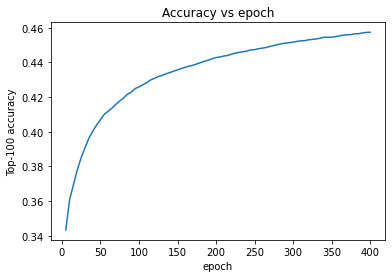

In [65]:
import matplotlib.pyplot as plt

num_validation_runs = len(history)
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, accuracy)
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
# plt.legend()

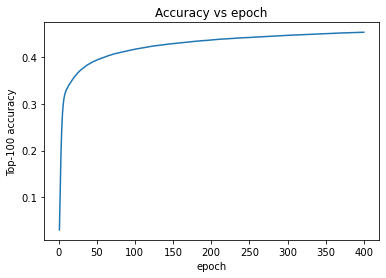

In [72]:
history=[]
accuracy=[]
history = model_1_history.history["factorized_top_k/top_100_categorical_accuracy"] + model_1_history_part2.history["factorized_top_k/top_100_categorical_accuracy"]
accuracy = model_1_history.history["factorized_top_k/top_100_categorical_accuracy"] + model_1_history_part2.history["factorized_top_k/top_100_categorical_accuracy"]

import matplotlib.pyplot as plt

num_validation_runs = len(history)
epochs = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs, accuracy)
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
# plt.legend()